In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
current_path = os.getcwd()
parent_directory = os.path.dirname(current_path)
sys.path.append(parent_directory)
from Class.jenie import Jenie
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import umap.umap_ as umap
import leidenalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from scipy.stats import zscore
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors
from umap import UMAP
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [4]:
plt.style.use('dark_background')

# Read in file

In [5]:
edu_pos_scdata = sc.read_h5ad(r"C:\Users\krist\Cleveland Lab Group\activation_of_quiescent_neurogenic_niches_of_aging_brain\4_week_edu_pos.h5ad")
edu_pos_scdata

AnnData object with n_obs × n_vars = 5143 × 275
    obs: 'volm', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'edu_median', 'edu_mean', 'edu_pos', 'leiden', 'celltype', 'x', 'cluster_names'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'celltype_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'x_colors'
    obsm: 'X_pca', 'X_raw', 'X_spatial', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Generate transcript count df based on 'cluster_names'

In [6]:
edu_pos_scdata.X

array([[0.99710341, 0.        , 0.35599812, ..., 0.35599812, 1.5786578 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 2.03619429,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.71913683,
        0.56717856],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.40314193, 0.        , 0.        , ..., 0.        , 2.32276838,
        0.        ],
       [1.6731199 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [7]:
raw_counts = edu_pos_scdata.obsm['X_raw']
#raw_counts

In [8]:
raw_count_df_column_name = list(edu_pos_scdata.var.index)
#raw_count_df_column_name

In [9]:
cluster_name_clusters = edu_pos_scdata.obs['cluster_names']
cluster_name_list = list(cluster_name_clusters.index)

In [10]:
raw_count_df = pd.DataFrame(raw_counts)
raw_count_df.columns = raw_count_df_column_name
raw_count_df = raw_count_df.T
raw_count_df.columns = cluster_name_list
raw_count_df = raw_count_df.T
raw_count_df = raw_count_df.assign(cluster_name_cluster = cluster_name_clusters)
raw_count_df = raw_count_df.groupby('cluster_name_cluster').sum()
#raw_count_df.to_csv('xenium_raw_count_leiden.csv',index=True, mode='w')
raw_count_df

,Abhd2,Acer3,Acta2,Actb,Actg1,Adarb2,Adcy1,Adcy2,Adgrl3,Agt,...,Vim,Vip,Vnn1,Vps13c,Wdr17,Wfs1,Wipf3,Wnt8b,Zbtb20,Zfp36l1
cluster_name_cluster,,,,,,,,,,,,,,,,,,,,,
Astro,1700.0,460.0,81.0,6300.0,3810.0,6431.0,3551.0,2505.0,7008.0,320.0,...,1456.0,479.0,56.0,936.0,487.0,2255.0,5673.0,131.0,4120.0,347.0
CLUSTER 16,72.0,20.0,5.0,320.0,235.0,367.0,186.0,137.0,380.0,11.0,...,45.0,7.0,5.0,48.0,24.0,401.0,206.0,5.0,235.0,18.0
CR / VLMC,461.0,158.0,18.0,2040.0,1528.0,1702.0,2119.0,102.0,1128.0,181.0,...,912.0,249.0,40.0,301.0,156.0,598.0,159.0,74.0,1961.0,208.0
Endo,482.0,58.0,32.0,1005.0,583.0,190.0,193.0,111.0,562.0,446.0,...,1811.0,80.0,8.0,63.0,46.0,183.0,166.0,60.0,1176.0,272.0
IT,806.0,241.0,38.0,3226.0,2295.0,4388.0,2267.0,1605.0,4192.0,92.0,...,170.0,61.0,24.0,517.0,256.0,1273.0,2806.0,74.0,1428.0,75.0
IT CTX,1319.0,423.0,39.0,4682.0,2394.0,6110.0,2626.0,2043.0,5946.0,127.0,...,267.0,57.0,26.0,750.0,354.0,671.0,5177.0,79.0,1776.0,84.0
IT ProS,1137.0,405.0,60.0,4343.0,3045.0,5546.0,2607.0,2625.0,6946.0,156.0,...,406.0,92.0,32.0,625.0,347.0,7993.0,3763.0,89.0,2013.0,136.0
L6 CT ENT,394.0,85.0,19.0,1411.0,1168.0,2346.0,752.0,1240.0,2227.0,45.0,...,143.0,42.0,10.0,235.0,117.0,649.0,677.0,17.0,751.0,56.0
Meis2,459.0,193.0,19.0,2126.0,1320.0,2160.0,995.0,804.0,2568.0,46.0,...,212.0,72.0,15.0,345.0,173.0,310.0,2061.0,34.0,983.0,63.0


### Plot gene expression bar graph for 'cluster_names'

In [11]:
cluster_name_array = np.array(edu_pos_scdata.obs['cluster_names'].unique())
cluster_name_array

array(['Oligo', 'CLUSTER 16', 'Astro', 'Meis2', 'CR / VLMC', 'Endo',
       'IT ProS', 'Ntng1 HPF', 'IT CTX', 'Pax6', 'IT', 'L6 CT ENT',
       'Micro-PVM', 'NP PPP'], dtype=object)

In [12]:
color_palette = sns.color_palette("Set2")
color_palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [13]:
sc.tl.rank_genes_groups(edu_pos_scdata, groupby = 'cluster_names')

In [14]:
raw_gene_array = np.empty((0,20))
for cluster in cluster_name_array:
    raw_gene_array_by_cluster = []
    for gene in edu_pos_scdata.uns['rank_genes_groups']['names'][cluster][:20]:
        raw_gene_array_by_cluster = np.append(raw_gene_array_by_cluster, raw_count_df.at[cluster, gene])
    raw_gene_array = np.vstack((raw_gene_array, raw_gene_array_by_cluster))
raw_gene_array

array([[5.6190e+03, 3.3780e+03, 1.2790e+03, 3.6400e+03, 4.2500e+03,
        1.4860e+03, 5.9800e+02, 1.9960e+03, 2.6050e+03, 6.3300e+02,
        9.7000e+02, 5.4900e+02, 4.2500e+02, 1.5310e+03, 1.4010e+03,
        4.0000e+02, 1.0740e+03, 7.6300e+02, 8.9700e+02, 2.6810e+03],
       [4.0400e+02, 2.9900e+02, 4.5700e+02, 1.4500e+02, 4.0100e+02,
        3.9900e+02, 8.2100e+02, 4.1600e+02, 6.0800e+02, 1.2660e+03,
        2.8800e+02, 9.7000e+01, 1.2600e+02, 2.1200e+02, 1.2600e+02,
        1.8200e+02, 2.4100e+02, 1.9300e+02, 2.1900e+02, 4.8600e+02],
       [1.6723e+04, 1.3710e+04, 2.4505e+04, 1.5384e+04, 8.3360e+03,
        5.7900e+03, 7.8960e+03, 8.2120e+03, 1.7050e+03, 2.1570e+03,
        2.1580e+03, 1.4460e+03, 1.1854e+04, 1.2600e+03, 2.9970e+03,
        8.4100e+02, 1.2160e+03, 9.6500e+02, 4.7900e+02, 2.1490e+03],
       [3.3970e+03, 3.2402e+04, 4.5720e+03, 3.4880e+03, 1.9050e+03,
        4.5930e+03, 1.3990e+03, 2.8370e+03, 1.4440e+03, 2.5250e+03,
        2.2906e+04, 1.4790e+03, 2.6530e+03, 4

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


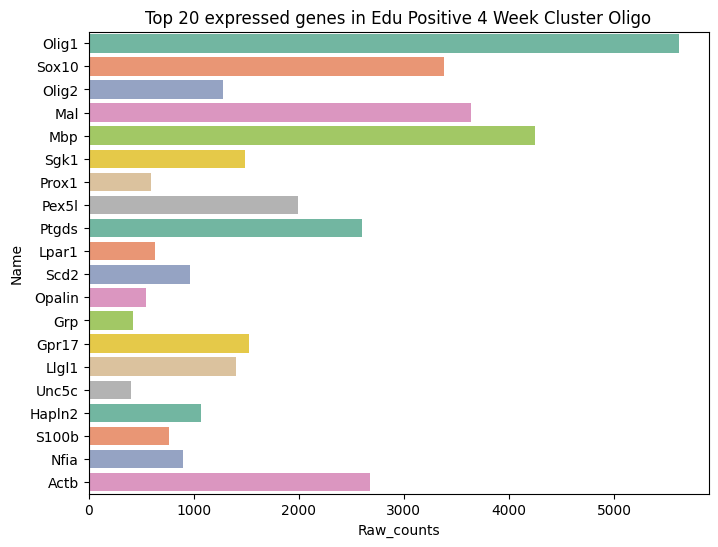

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


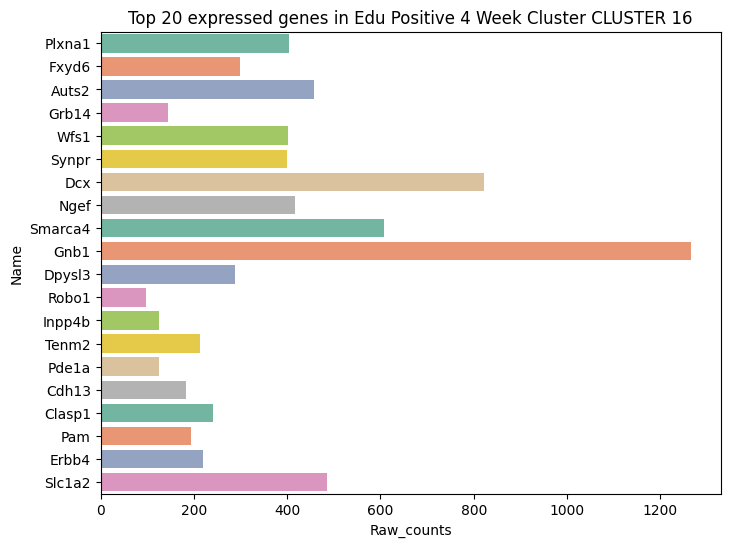

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


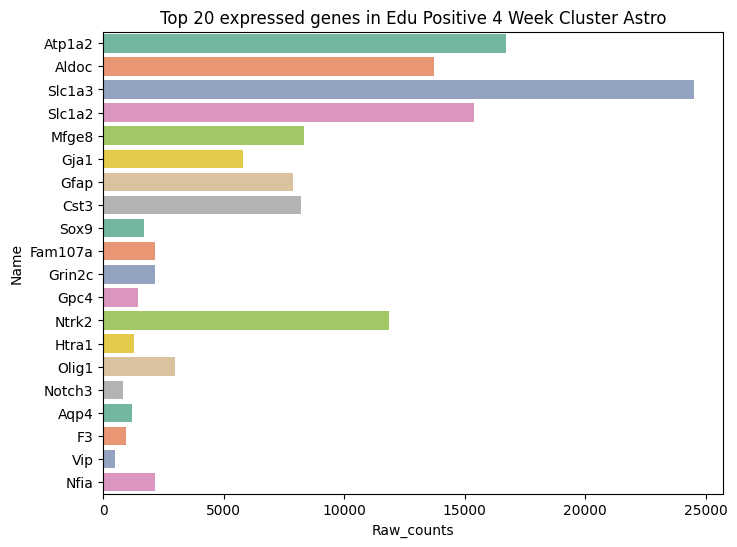

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


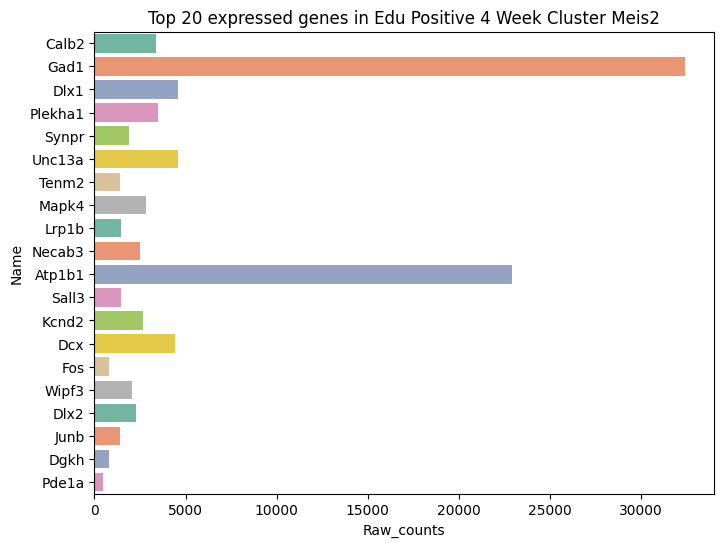

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


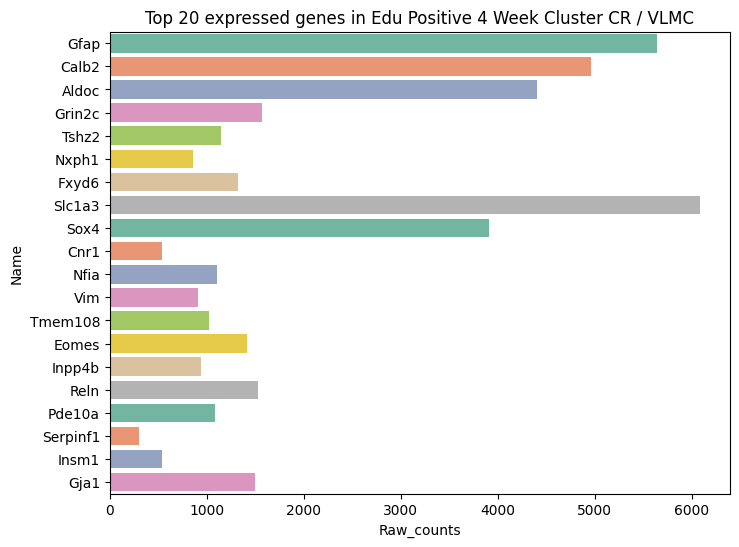

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


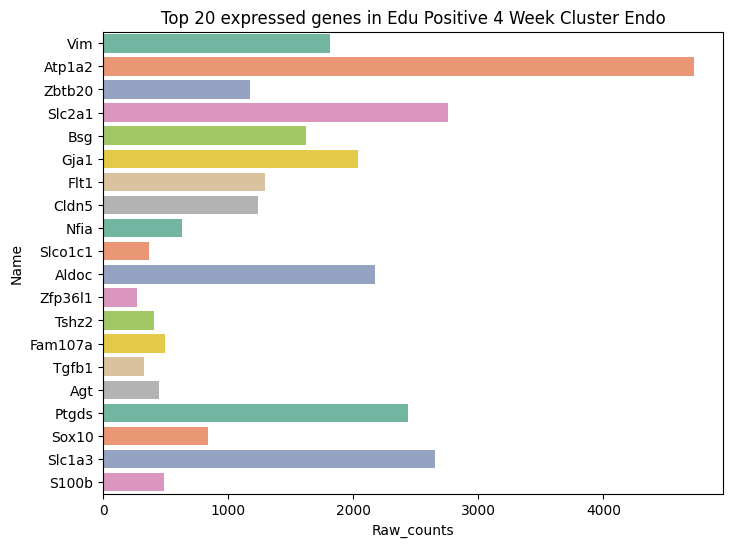

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


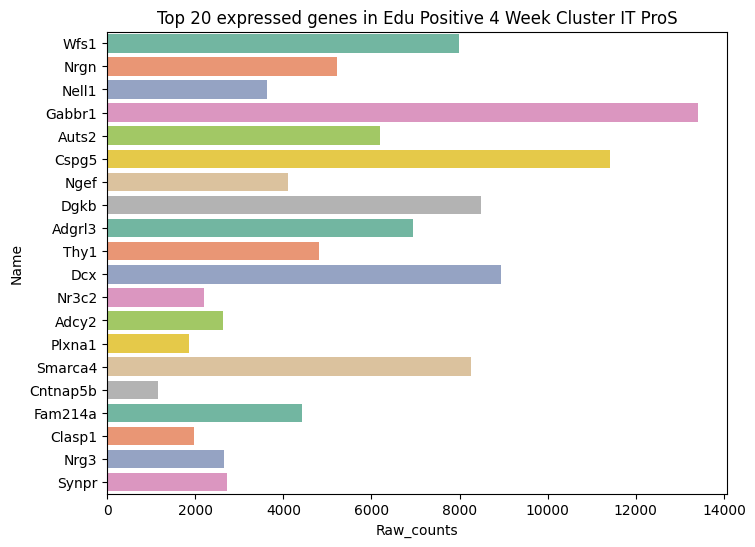

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


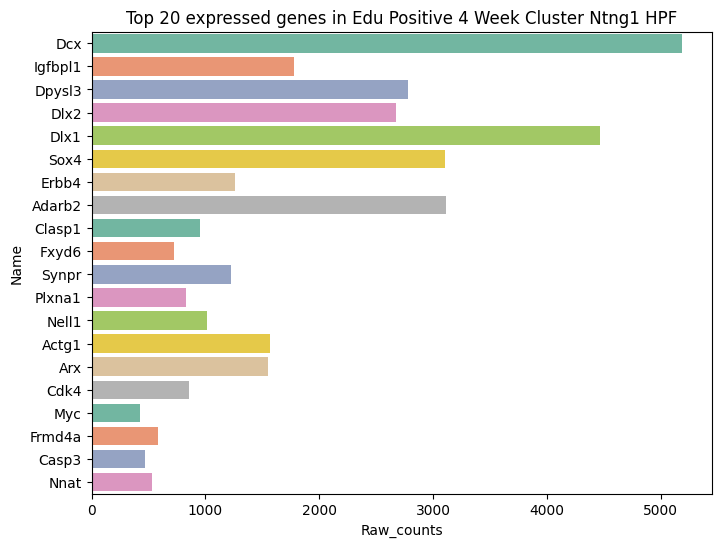

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


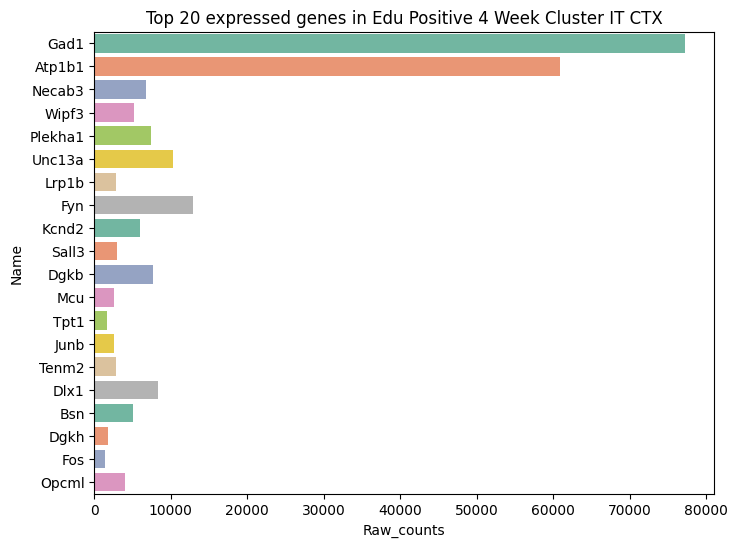

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


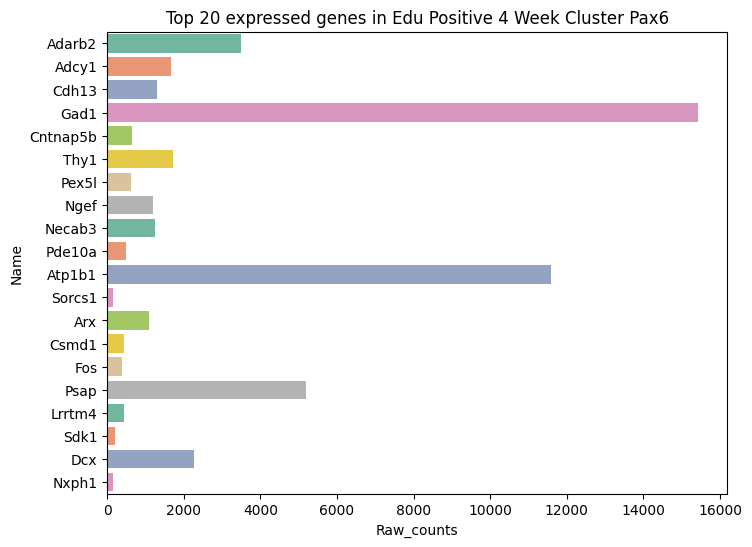

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


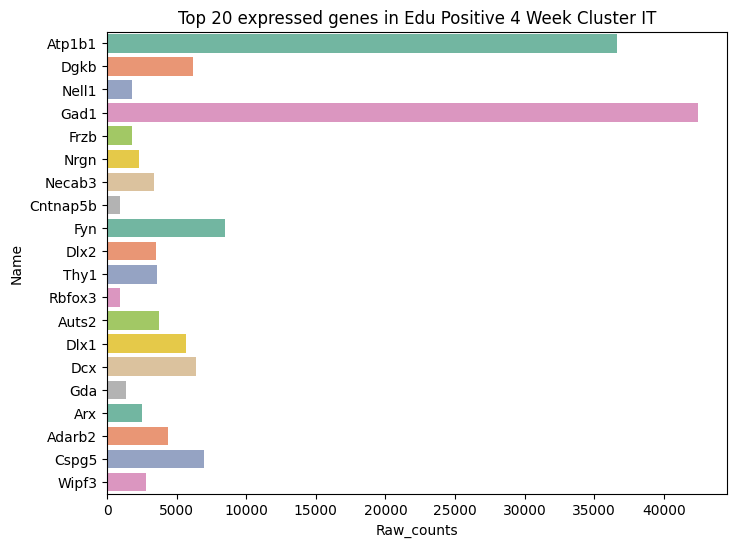

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


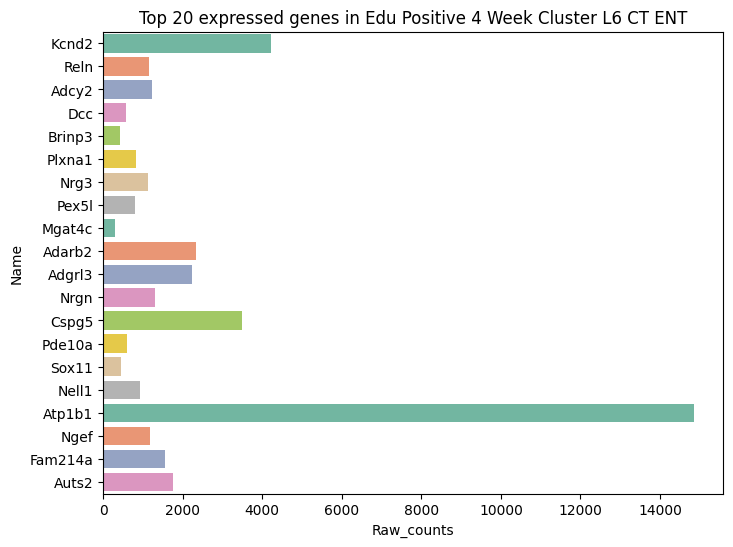

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


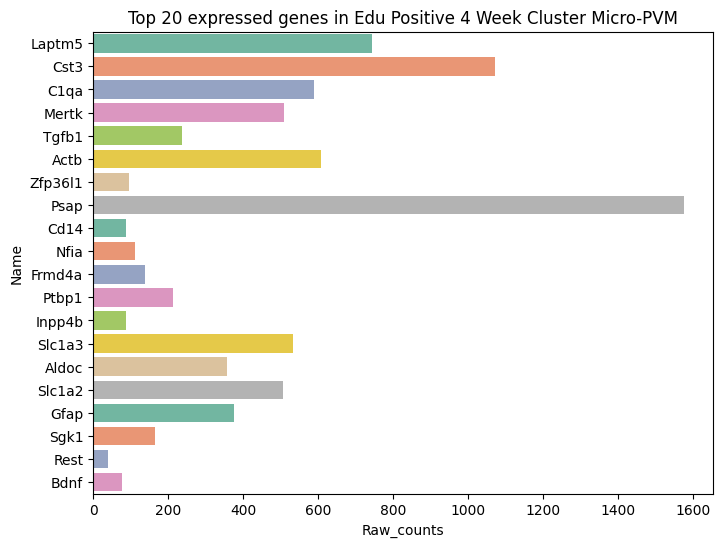

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\433162519.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


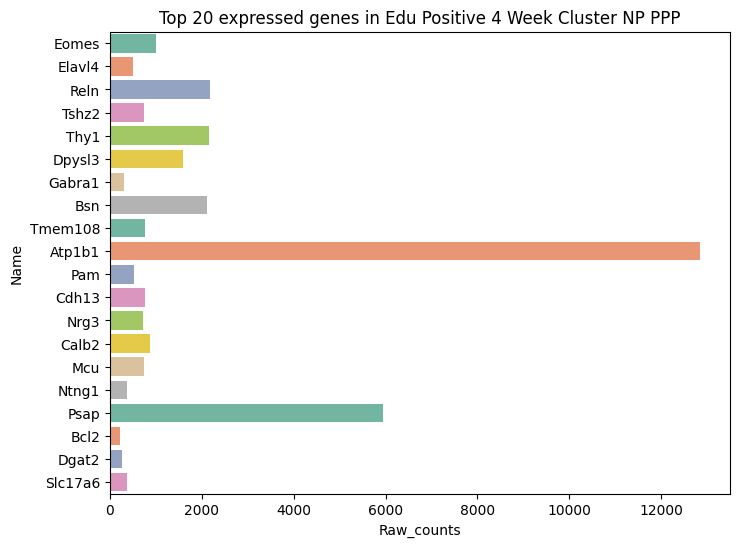

In [15]:
for cluster, i in zip(cluster_name_array, range(len(raw_gene_array))):
    x_label = raw_gene_array[i]
    y_label = edu_pos_scdata.uns['rank_genes_groups']['names'][cluster][:20]
    graph_df = pd.DataFrame().assign(Name = y_label).assign(Raw_counts = x_label)
    #graph_df
    plt.style.use('default')
    plt.figure(figsize = (8, 6))
    sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
    plt.title(f'Top 20 expressed genes in Edu Positive 4 Week Cluster {cluster}')
    #plt.savefig(f'Xenium Cluster {cluster} top 20 gene expression bar chart')
    plt.show()

### Generate transcript count df for 'leiden'

In [23]:
leiden_clusters = edu_pos_scdata.obs['leiden']
leiden_list = list(leiden_clusters.index)

In [25]:
raw_count_df_leiden = pd.DataFrame(raw_counts)
raw_count_df_leiden.columns = raw_count_df_column_name
raw_count_df_leiden = raw_count_df_leiden.T
raw_count_df_leiden.columns = leiden_list
raw_count_df_leiden = raw_count_df_leiden.T
raw_count_df_leiden = raw_count_df_leiden.assign(leiden_cluster = leiden_clusters)
raw_count_df_leiden = raw_count_df_leiden.groupby('leiden_cluster').sum()
#raw_count_df_leiden.to_csv('xenium_raw_count_leiden.csv',index=True, mode='w')
raw_count_df_leiden

,Abhd2,Acer3,Acta2,Actb,Actg1,Adarb2,Adcy1,Adcy2,Adgrl3,Agt,...,Vim,Vip,Vnn1,Vps13c,Wdr17,Wfs1,Wipf3,Wnt8b,Zbtb20,Zfp36l1
leiden_cluster,,,,,,,,,,,,,,,,,,,,,
0,1319.0,423.0,39.0,4682.0,2394.0,6110.0,2626.0,2043.0,5946.0,127.0,...,267.0,57.0,26.0,750.0,354.0,671.0,5177.0,79.0,1776.0,84.0
1,1285.0,340.0,55.0,4527.0,2834.0,4921.0,2841.0,1897.0,5362.0,196.0,...,688.0,281.0,40.0,731.0,350.0,899.0,4554.0,87.0,2250.0,190.0
2,1137.0,405.0,60.0,4343.0,3045.0,5546.0,2607.0,2625.0,6946.0,156.0,...,406.0,92.0,32.0,625.0,347.0,7993.0,3763.0,89.0,2013.0,136.0
3,461.0,158.0,18.0,2040.0,1528.0,1702.0,2119.0,102.0,1128.0,181.0,...,912.0,249.0,40.0,301.0,156.0,598.0,159.0,74.0,1961.0,208.0
4,459.0,193.0,19.0,2126.0,1320.0,2160.0,995.0,804.0,2568.0,46.0,...,212.0,72.0,15.0,345.0,173.0,310.0,2061.0,34.0,983.0,63.0
5,434.0,111.0,18.0,1741.0,1183.0,2886.0,1392.0,850.0,2099.0,61.0,...,104.0,25.0,14.0,262.0,150.0,274.0,1243.0,43.0,520.0,39.0
6,415.0,120.0,26.0,1773.0,976.0,1510.0,710.0,608.0,1646.0,124.0,...,768.0,198.0,16.0,205.0,137.0,1356.0,1119.0,44.0,1870.0,157.0
7,367.0,88.0,25.0,2138.0,1570.0,3109.0,1258.0,720.0,2225.0,59.0,...,202.0,39.0,10.0,228.0,157.0,615.0,791.0,45.0,932.0,70.0
8,372.0,130.0,20.0,1485.0,1112.0,1502.0,875.0,755.0,2093.0,31.0,...,66.0,36.0,10.0,255.0,106.0,999.0,1563.0,31.0,908.0,36.0


### Plot gene expression bar graph for leiden

In [29]:
leiden_array = np.array(edu_pos_scdata.obs['leiden'].unique())
leiden_array

array(['11', '16', '1', '4', '6', '14', '3', '12', '2', '7', '0', '10',
       '5', '9', '8', '15', '13'], dtype=object)

In [30]:
color_palette = sns.color_palette("Set2")
color_palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [31]:
sc.tl.rank_genes_groups(edu_pos_scdata, groupby = 'leiden')

In [33]:
raw_gene_array = np.empty((0,20))
for cluster in leiden_array:
    raw_gene_array_by_cluster = []
    for gene in edu_pos_scdata.uns['rank_genes_groups']['names'][cluster][:20]:
        raw_gene_array_by_cluster = np.append(raw_gene_array_by_cluster, raw_count_df_leiden.at[cluster, gene])
    raw_gene_array = np.vstack((raw_gene_array, raw_gene_array_by_cluster))
raw_gene_array

array([[3.3510e+03, 3.5900e+03, 2.3290e+03, 1.8680e+03, 3.7930e+03,
        2.5850e+03, 5.8000e+02, 5.1900e+02, 6.7000e+02, 1.2170e+03,
        8.5900e+02, 1.1580e+03, 5.3500e+02, 1.0400e+03, 8.1700e+02,
        4.4700e+02, 1.9940e+03, 2.5100e+02, 2.7700e+02, 3.4400e+02],
       [4.0400e+02, 2.9900e+02, 4.5700e+02, 1.4500e+02, 4.0100e+02,
        3.9900e+02, 8.2100e+02, 4.1600e+02, 6.0800e+02, 1.2660e+03,
        2.8800e+02, 9.7000e+01, 1.2600e+02, 2.1200e+02, 1.2600e+02,
        1.8200e+02, 2.4100e+02, 1.9300e+02, 2.1900e+02, 4.8600e+02],
       [8.7020e+03, 8.5850e+03, 1.0066e+04, 1.1021e+04, 7.2401e+04,
        2.8040e+03, 6.0870e+03, 4.5170e+03, 2.1620e+03, 2.1090e+03,
        1.4320e+03, 1.3210e+03, 4.5540e+03, 5.3433e+04, 2.7570e+03,
        4.3710e+03, 7.5000e+02, 2.5680e+03, 2.8520e+03, 1.2602e+04],
       [3.3970e+03, 3.2402e+04, 4.5720e+03, 3.4880e+03, 1.9050e+03,
        4.5930e+03, 1.3990e+03, 2.8370e+03, 1.4440e+03, 2.5250e+03,
        2.2906e+04, 1.4790e+03, 2.6530e+03, 4

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


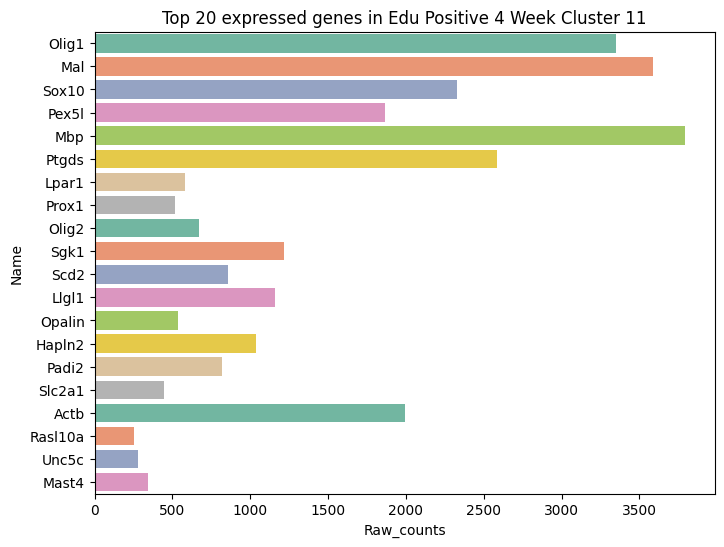

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


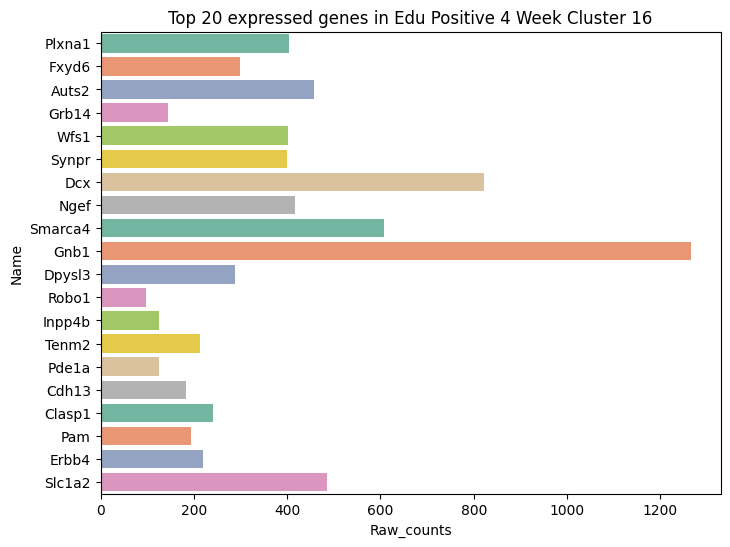

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


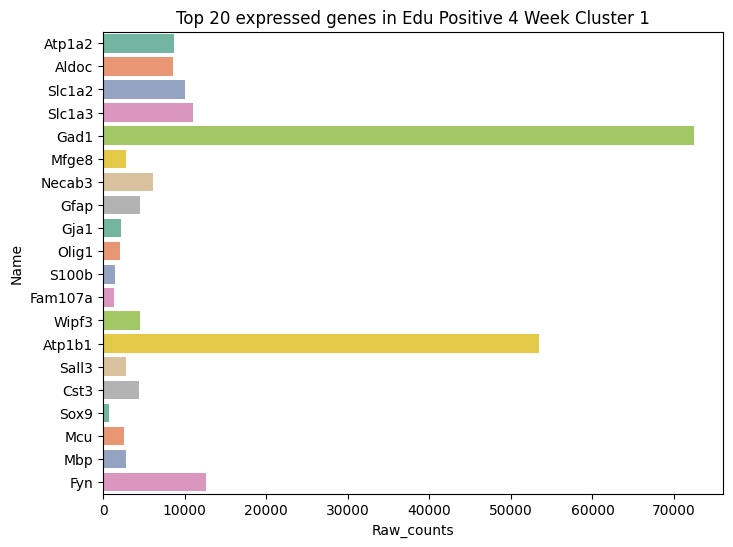

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


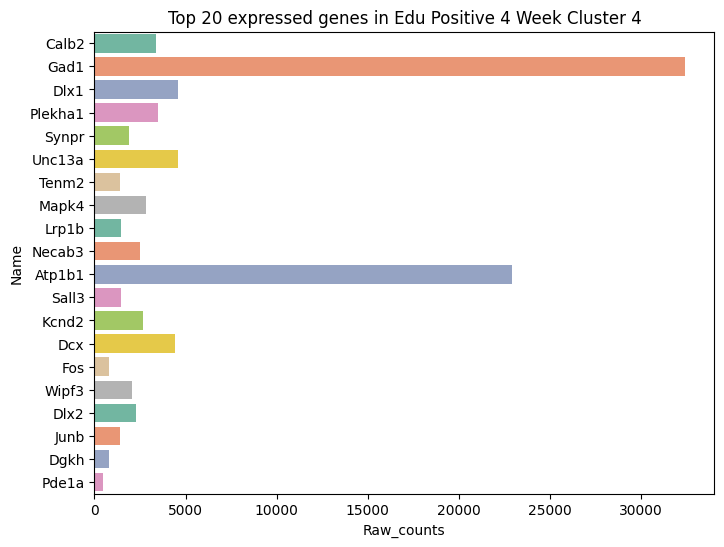

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


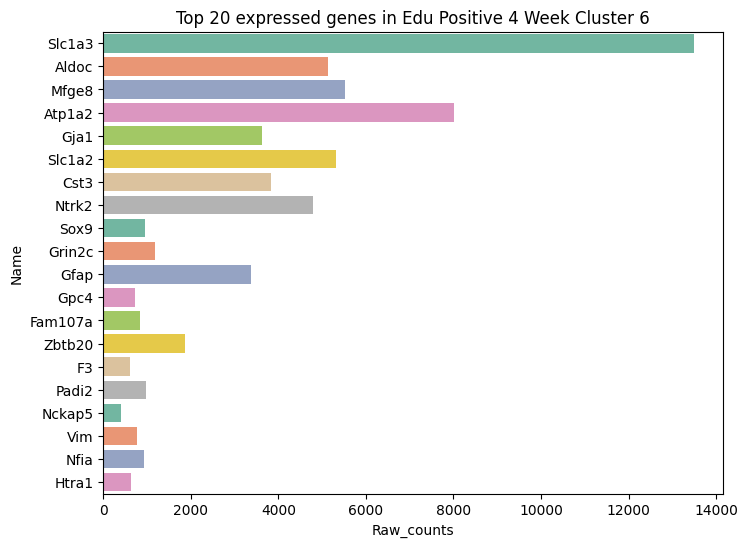

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


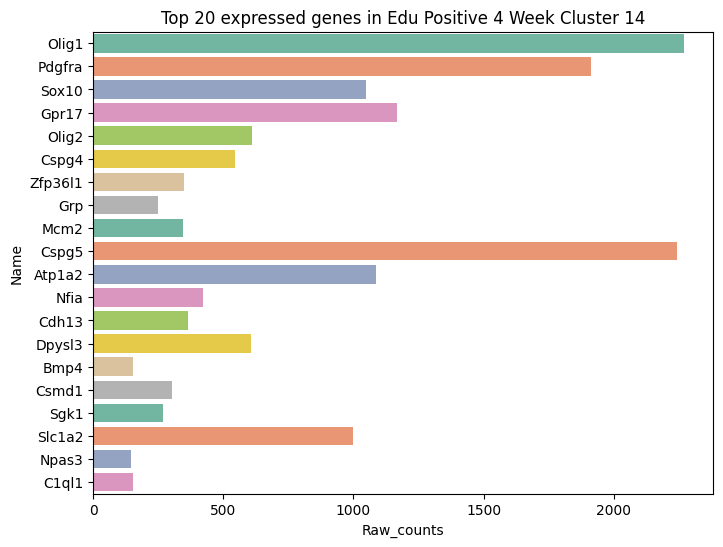

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


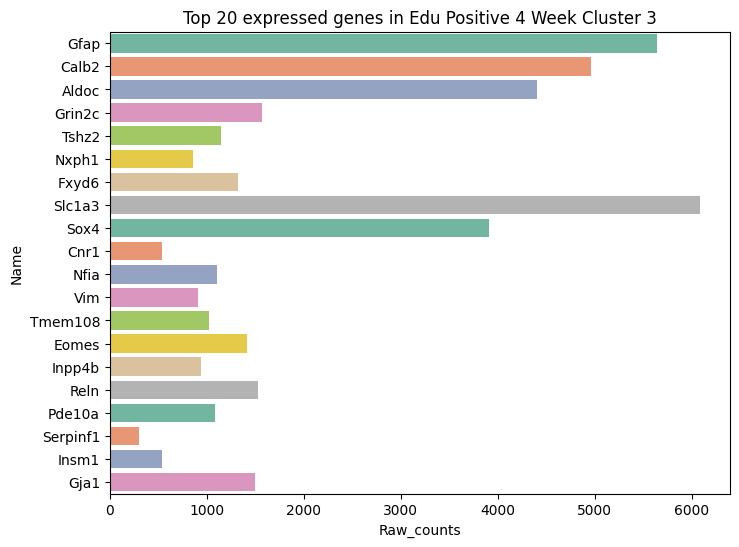

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


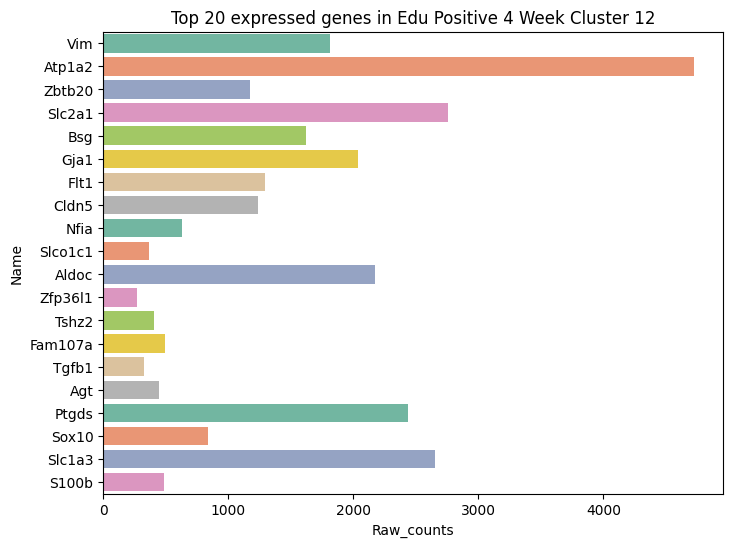

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


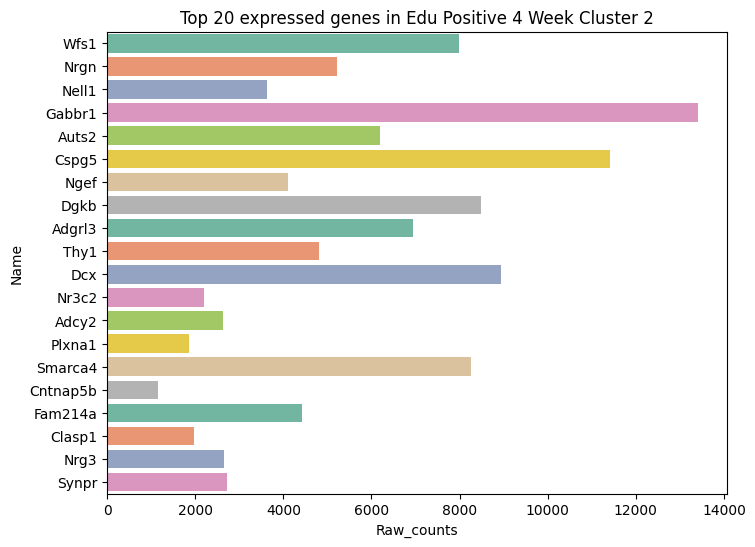

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


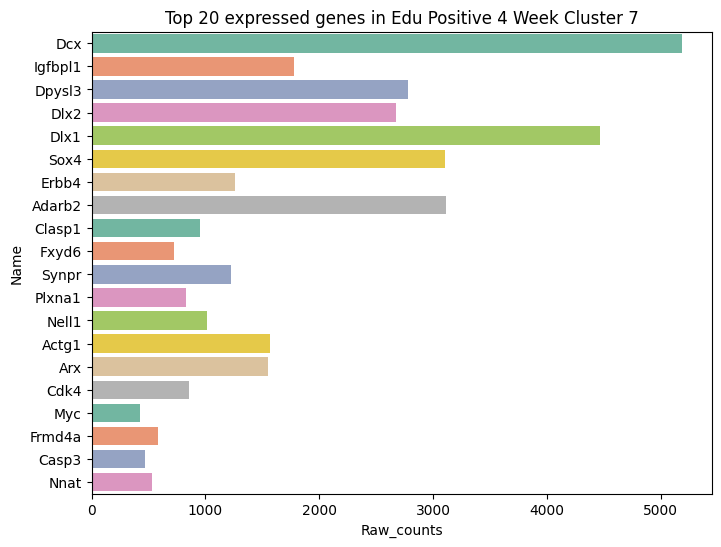

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


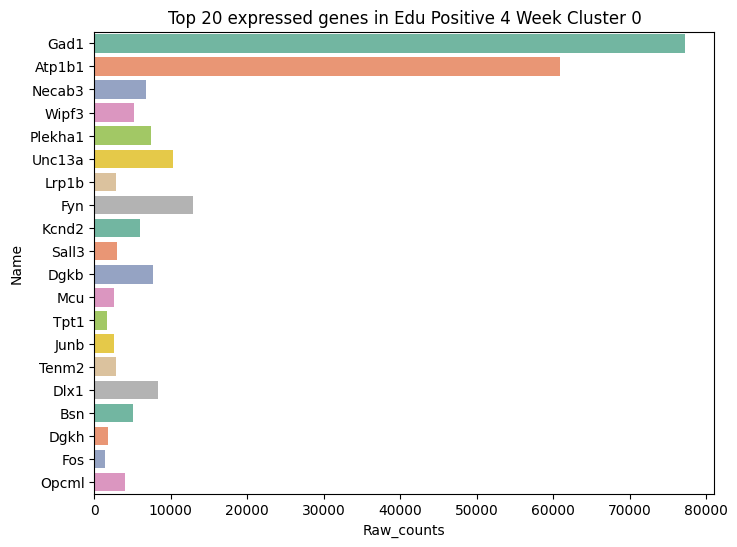

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


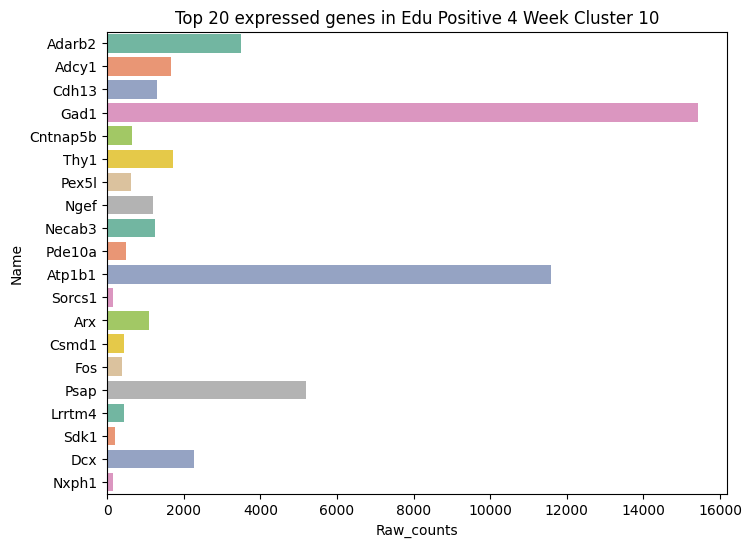

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


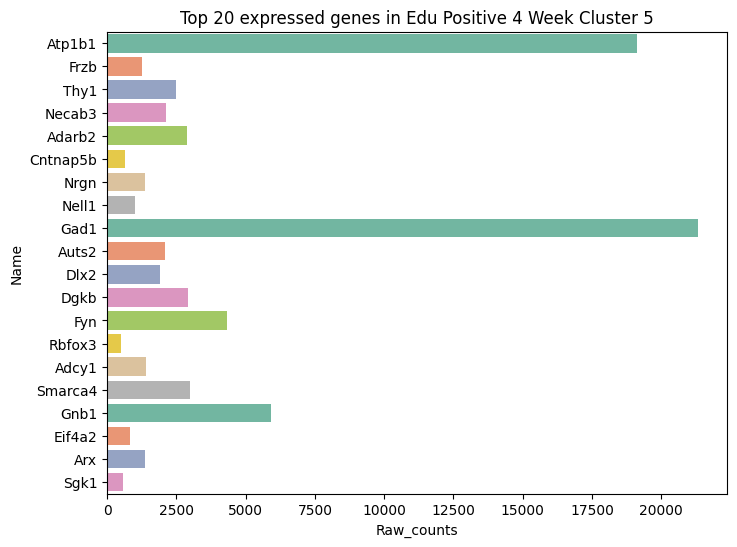

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


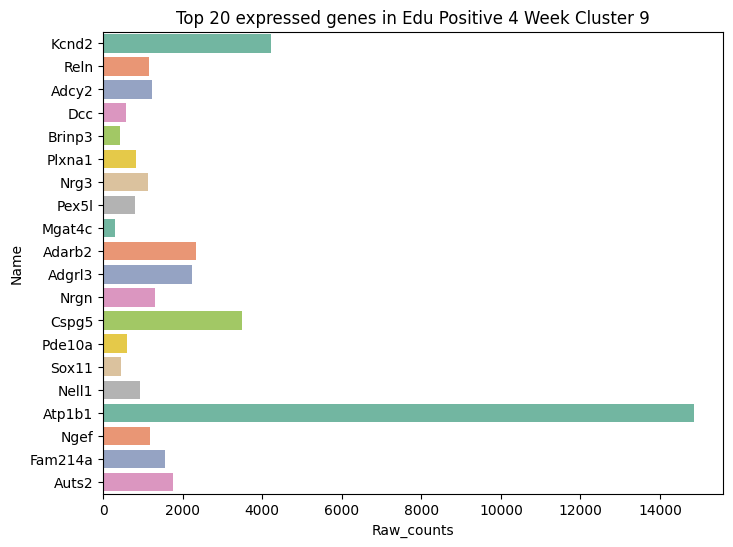

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


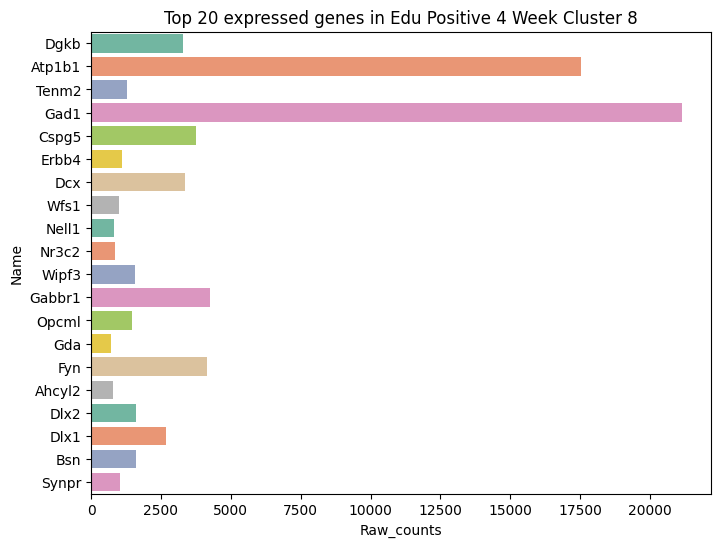

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


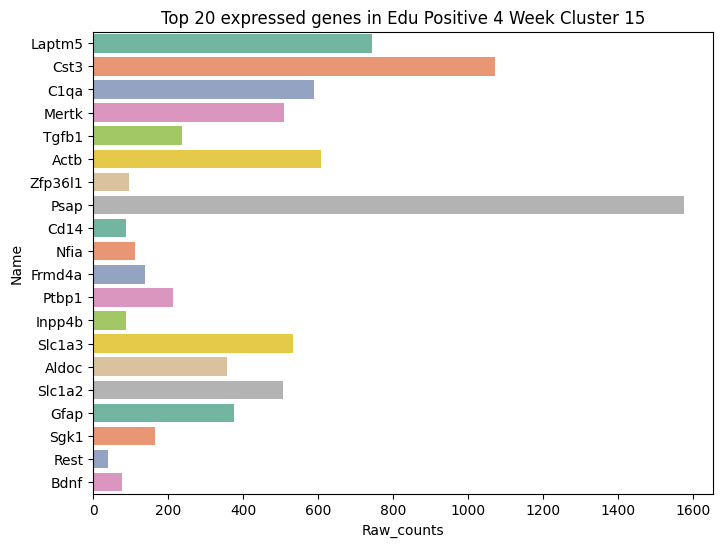

C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
C:\Users\krist\AppData\Local\Temp\ipykernel_30476\2352640629.py:8: UserWarning: 
The palette list has fewer values (8) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)


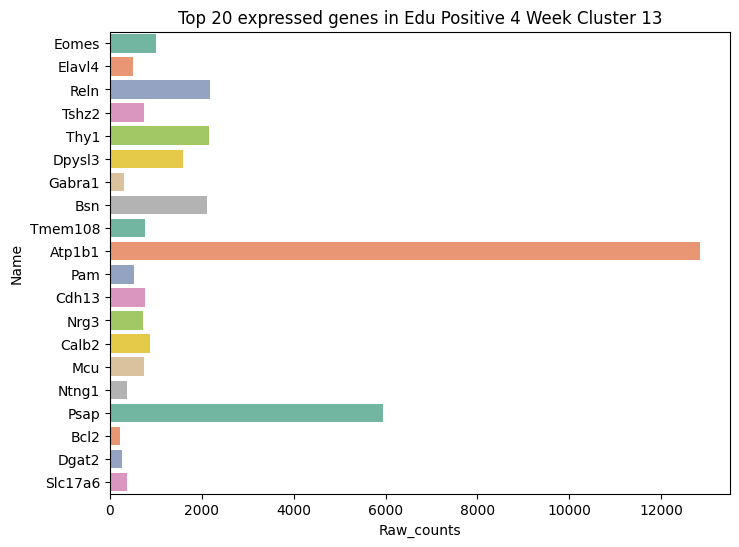

In [34]:
for cluster, i in zip(leiden_array, range(len(raw_gene_array))):
    x_label = raw_gene_array[i]
    y_label = edu_pos_scdata.uns['rank_genes_groups']['names'][cluster][:20]
    graph_df = pd.DataFrame().assign(Name = y_label).assign(Raw_counts = x_label)
    #graph_df
    plt.style.use('default')
    plt.figure(figsize = (8, 6))
    sns.barplot(graph_df, x = 'Raw_counts', y = 'Name', orient = 'y', palette = color_palette)
    plt.title(f'Top 20 expressed genes in Edu Positive 4 Week Cluster {cluster}')
    #plt.savefig(f'Xenium Cluster {cluster} top 20 gene expression bar chart')
    plt.show()